In [1]:

#importando a biblioteca PySpark
import pyspark
from pyspark.sql import SparkSession
import time


spark = SparkSession.builder \
      .master("local[1]") \
      .appName("salaries-csvs") \
      .getOrCreate()

In [2]:
%time
# Abrindo o 1° csv

start_time = time.time()

df_1 = spark.read.csv('Employers_Data.csv', sep=',', inferSchema=True, header=True)
df_1.show()


print("Tempo de execução: {:.2f} segundos".format(time.time() - start_time))

Wall time: 0 ns
+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
|JOB1362684407692|   113|
|JOB1362684407693|   178|
|JOB1362684407694|    73|
|JOB1362684407695|    31|
|JOB1362684407696|   104|
|JOB1362684407697|   102|
|JOB1362684407698|   144|
|JOB1362684407699|    79|
|JOB1362684407700|   193|
|JOB1362684407701|    47|
|JOB1362684407702|   172|
|JOB1362684407703|    47|
|JOB1362684407704|   126|
|JOB1362684407705|   122|
|JOB1362684407706|    95|
+----------------+------+
only showing top 20 rows

Tempo de execução: 5.53 segundos


In [3]:
%time
# Abrindo o 2° csv

start_time = time.time()

df_2 = spark.read.csv('Salary_Data.csv', sep=',', inferSchema=True, header=True)
df_2.show()

print("Tempo de execução: {:.2f} segundos".format(time.time() - start_time))

Wall time: 0 ns
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|   PHYSICS|   HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|   PHYSICS|  FINANCE|              8|                 16|
|JOB1362684407692|   COMP15|       MANAGER|   DOCTORAL|   COMPSCI|  FINANCE|    

In [4]:
df_1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



In [5]:
df_2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



Os dados estão em formato correto, então o primeiro passo é unir os dois datasets

In [6]:
%time
# Renomeando coluna job_Id para evitar ambiguidade na hora de dropar dados
df_2 = df_2.withColumnRenamed('jobId', 'jobId2')

Wall time: 0 ns


In [7]:
%time
# Juntando datasets

start_time = time.time()

df = df_1.join(df_2, df_1.jobId == df_2.jobId2)
df = df.drop('jobId2')
df.show()

print("Tempo de execução: {:.2f} segundos".format(time.time() - start_time))

Wall time: 0 ns
+----------------+------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|           jobId|salary|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|
+----------------+------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|JOB1362684407687|   130|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|
|JOB1362684407688|   101|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|
|JOB1362684407689|   137|   COMP52|VICE_PRESIDENT|   DOCTORAL|   PHYSICS|   HEALTH|             10|                 38|
|JOB1362684407690|   142|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|
|JOB1362684407691|   163|    COMP7|VICE_PRESIDENT|  BACHELORS|   PHYSICS|  FINANCE|              8|                 16|
|JOB1362684407692|   113

In [8]:
# Contagem de linhas distintas

%time

start_time = time.time()

distinctDF = df.distinct()
print("Distinct count: "+str(distinctDF.count()))
distinctDF.show(truncate=False)

print("Tempo de execução: {:.2f} segundos".format(time.time() - start_time))

Wall time: 0 ns
Distinct count: 1000000
+----------------+------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|jobId           |salary|companyId|jobType       |degree     |major     |industry |yearsExperience|milesFromMetropolis|
+----------------+------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|JOB1362684407687|130   |COMP37   |CFO           |MASTERS    |MATH      |HEALTH   |10             |83                 |
|JOB1362684407688|101   |COMP19   |CEO           |HIGH_SCHOOL|NONE      |WEB      |3              |73                 |
|JOB1362684407689|137   |COMP52   |VICE_PRESIDENT|DOCTORAL   |PHYSICS   |HEALTH   |10             |38                 |
|JOB1362684407690|142   |COMP38   |MANAGER       |DOCTORAL   |CHEMISTRY |AUTO     |8              |17                 |
|JOB1362684407691|163   |COMP7    |VICE_PRESIDENT|BACHELORS  |PHYSICS   |FINANCE  |8              |16                 |


De todos os nossos 1 milhões de registros, todos são, em algum grau, diferentes uns dos outros, ou seja, nossa tabela não possui valores duplicados.

#### Chegagem de Nulos

In [9]:
# Checagem de Nulos com a função isNull do pySpark

from pyspark.sql import functions as F

start_time = time.time()

df.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

print("Tempo de execução: {:.2f} segundos".format(time.time() - start_time))

+-----+------+---------+-------+------+-----+--------+---------------+-------------------+
|jobId|salary|companyId|jobType|degree|major|industry|yearsExperience|milesFromMetropolis|
+-----+------+---------+-------+------+-----+--------+---------------+-------------------+
|    0|     0|        0|      0|     0|    0|       0|              0|                  0|
+-----+------+---------+-------+------+-----+--------+---------------+-------------------+

Tempo de execução: 5.40 segundos


Os valores nulos estão descritos como o valor None, por isso, faremos a contagem sem comandos automáticos

In [10]:
print('Number of missing values for jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Number of missing values for degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Number of missing values for major: {}'.format(df.filter(df.major=='NONE').count()))
print('Number of missing values for industry: {}'.format(df.filter(df.industry=='NONE').count()))

Number of missing values for jobType: 0
Number of missing values for degree: 236854
Number of missing values for major: 532355
Number of missing values for industry: 0


Esses valores não são nulos, de fato, mas acionam a falta de um ou mais atributos nos funcionários.

### EDA

In [12]:
%time

start_time = time.time()

df.describe().show()

print("Tempo de execução: {:.2f} segundos".format(time.time() - start_time))

Wall time: 0 ns
+-------+----------------+-----------------+---------+--------------+---------+-------+--------+-----------------+-------------------+
|summary|           jobId|           salary|companyId|       jobType|   degree|  major|industry|  yearsExperience|milesFromMetropolis|
+-------+----------------+-----------------+---------+--------------+---------+-------+--------+-----------------+-------------------+
|  count|         1000000|          1000000|  1000000|       1000000|  1000000|1000000| 1000000|          1000000|            1000000|
|   mean|            null|       116.061818|     null|          null|     null|   null|    null|        11.992386|           49.52926|
| stddev|            null|38.71793638113437|     null|          null|     null|   null|    null|7.212390868885633| 28.877732628720313|
|    min|JOB1362684407687|                0|    COMP0|           CEO|BACHELORS|BIOLOGY|    AUTO|                0|                  0|
|    max|JOB1362685407686|             

In [15]:
df.show()

+----------------+------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|           jobId|salary|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|
+----------------+------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|JOB1362684407687|   130|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|
|JOB1362684407688|   101|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|
|JOB1362684407689|   137|   COMP52|VICE_PRESIDENT|   DOCTORAL|   PHYSICS|   HEALTH|             10|                 38|
|JOB1362684407690|   142|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|
|JOB1362684407691|   163|    COMP7|VICE_PRESIDENT|  BACHELORS|   PHYSICS|  FINANCE|              8|                 16|
|JOB1362684407692|   113|   COMP15|     

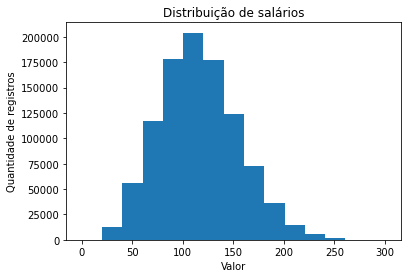

In [28]:
import matplotlib.pyplot as plt

# Converter o DataFrame PySpark em Pandas
pdf = df.toPandas()

# Plotar um histograma
plt.hist(pdf['salary'], bins=15)
plt.xlabel('Valor')
plt.ylabel('Quantidade de registros')
plt.title('Distribuição de salários')
plt.show()

In [32]:
plt.bar(pdf['jobType'], pdf['salary'].mean())
plt.xlabel('Função')
plt.ylabel('Salário')
plt.title('Salários por função')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000295441C4DC0> (for post_execute):


KeyboardInterrupt: 

### Análises

Diferenças salariais

In [42]:
# Criando a temp view

df = df.where("salary != 0") 
df.createOrReplaceTempView('data')

In [43]:
# Média salarial por função

spark.sql('''
          SELECT jobType as job, AVG(salary) as average_salary
          FROM data
          GROUP BY job
          ORDER BY average_salary DESC
          ''').show()

+--------------+------------------+
|           job|    average_salary|
+--------------+------------------+
|           CEO|145.31142509096154|
|           CTO|135.48106681594626|
|           CFO|135.45854674396352|
|VICE_PRESIDENT| 125.3686299247808|
|       MANAGER| 115.3685182225064|
|        SENIOR|105.48777465325772|
|        JUNIOR| 95.33308719660974|
|       JANITOR| 70.81304462635332|
+--------------+------------------+



In [44]:
# Olhando os 10 salários mais altos

spark.sql('''
          SELECT jobType as job, industry, salary, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 10
          ''').show()

+---+--------+------+----+
|job|industry|salary|Rank|
+---+--------+------+----+
|CFO|     OIL|   301|   1|
|CTO|     OIL|   301|   1|
|CEO|     OIL|   298|   3|
|CEO| FINANCE|   294|   1|
|CEO|     OIL|   294|   4|
|CEO| FINANCE|   293|   2|
|CEO|     OIL|   293|   5|
|CEO| FINANCE|   292|   3|
|CTO| FINANCE|   292|   3|
|CEO|     WEB|   290|   1|
+---+--------+------+----+



In [45]:
# Olhando os 10 salários mais baixos

spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC
          LIMIT 10
          ''').show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
+------+-------+---------+----+



In [46]:
# Média salarial por industria

spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC
          ''').show()

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



In [47]:
# Média salarial por graduação

spark.sql('''
          SELECT degree, AVG(salary) as average_salary
          FROM data
          GROUP BY degree
          ORDER BY average_salary DESC
          ''').show()

+-----------+------------------+
|     degree|    average_salary|
+-----------+------------------+
|   DOCTORAL|135.49097866128352|
|    MASTERS|130.50564713935316|
|  BACHELORS|125.45466252599789|
|HIGH_SCHOOL|101.92108450258466|
|       NONE| 98.17688186343428|
+-----------+------------------+



Análise de tempo de experiência

In [59]:
from scipy import stats
import seaborn as sns

In [66]:
# Analisando os salários por tempo de serviço

df_exp = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''') 
df_exp.show()

job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO|     OIL|             19|
|   294|    CEO| FINANCE|             24|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CTO| FINANCE|             24|
|   292|    CEO| FINANCE|             22|
|   290|    CEO|     WEB|             20|
|   289|    CEO| FINANCE|             23|
|   289|    CTO|     WEB|             24|
|   289|    CFO|     OIL|             23|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO|     OIL|             22|
|   287|    CEO| FINANCE|             19|
|   286|    CEO|     OIL|             16|
|   286|    CTO| FINANCE|             24|
|   286|    CEO| FINANCE|             24|
+------+-------+--------+---------

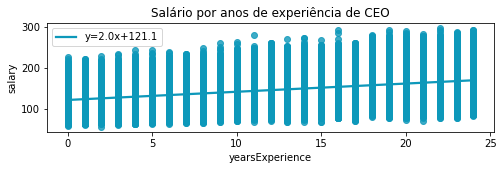

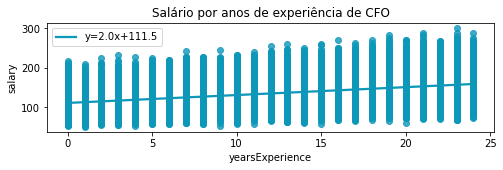

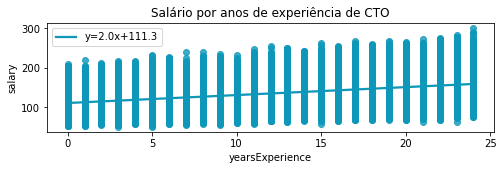

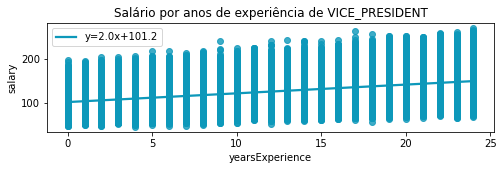

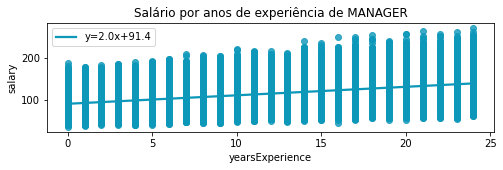

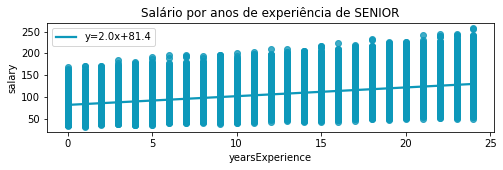

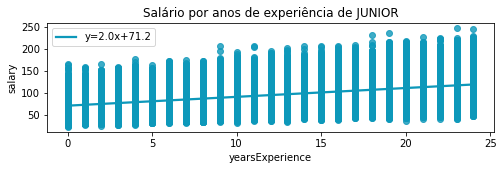

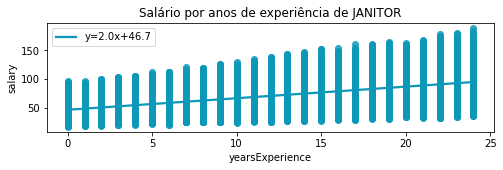

Tempo de execução: 64.71 segundos


In [67]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

df_exp = df_exp.toPandas()


start_time = time.time()

for job in job_list:
    df_x = df_exp.loc[df_exp['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salário por anos de experiência de ' + job)
    plt.savefig(f'y_exp_{job}.png', format='png')
    plt.show()
    

print("Tempo de execução: {:.2f} segundos".format(time.time() - start_time))